# 💼 성인 연봉 데이터 분석 with AutoGluon (v1.4)

이 노트북에서는 **Adult Income (salary2.csv)** 데이터를 이용해서  
`AutoGluon` 라이브러리로 **연봉이 50K 초과인지 여부(>50K vs <=50K)를 자동으로 예측하는 모델**을 만들어 본다.

## ✅ 학습 목표

1. AutoGluon Tabular의 기본 사용법 이해  
2. 기존에 하던 수작업 전처리 / 모델링(DecisionTree, RandomForest 등)과의 차이 이해  
3. 리더보드(leaderboard)로 여러 모델의 성능을 한 번에 비교하는 방법 익히기  
4. Feature Importance로 **연봉에 영향을 많이 주는 변수** 해석하기


## 1. AutoGluon 설치

수업 환경(예: 구글 코랩, 로컬 PC 가상환경 등)에 따라 다음 명령어로 AutoGluon을 설치한다.

> **⚠️ 주의:** AutoGluon은 설치 시간이 조금 걸릴 수 있다.  
> 가능한 한 **새 가상환경(venv / conda)**에서 사용하는 것을 추천한다.

```bash
!pip install -U "torch"
!pip install "autogluon.tabular[fastai]==1.4.0"
```

아래 코드는 노트북에서 직접 설치하고 싶을 때 사용하는 예시이다.  
(이미 설치했다면 다시 실행할 필요는 없다.)


In [1]:
# !pip install -U "torch"
# !pip install "autogluon.tabular[fastai]==1.4.0"
# 설치가 오래 걸릴 수 있으니, 필요할 때만 실행하세요.

## 2. 라이브러리 불러오기

데이터 분석에 필요한 기본 라이브러리와 AutoGluon을 불러온다.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score
)

from autogluon.tabular import TabularPredictor

pd.set_option("display.max_columns", 50)


## 3. 데이터 불러오기 및 기본 전처리

### 3.1 salary2.csv 불러오기

- Adult Income 기반의 연봉 데이터셋을 사용한다.
- 파일 위치는 `./data/salary2.csv` 라고 가정한다.


In [3]:
# 데이터 불러오기
data = pd.read_csv("./data/salary2.csv")

print("데이터 크기:", data.shape)
data.head()


데이터 크기: (48842, 14)


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


### 3.2 중복 제거 & 결측값 제거

- **중복 행(drop_duplicates)**: 같은 사람이 여러 번 기록되었을 수 있어서 제거
- **결측값 제거(dropna)**: 결측치가 있는 행은 간단하게 제거 (수업용 예제라서)
- 인덱스를 다시 0부터 재설정한다.


In [4]:
# 중복 제거
data = data.drop_duplicates()

# 결측값 제거
data = data.dropna()

# 인덱스 재설정
data = data.reset_index(drop=True)

print("전처리 후 데이터 크기:", data.shape)
data.head()


전처리 후 데이터 크기: (39240, 14)


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,34,Private,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


### 3.3 타깃 변수 `class` 이진 변환

원본 데이터의 `class` 컬럼은 문자열 형태이다. (예: `' >50K'`, `' <=50K'`)

- `' >50K'`  →  **1 (연봉 50K 초과)**  
- 그 외(예: `' <=50K'`) → **0 (연봉 50K 이하)**

이렇게 바꿔야 머신러닝 모델이 **이진 분류 문제(binary classification)**로 다룰 수 있다.


In [5]:
# class 컬럼을 0/1로 변환
data['class'] = data['class'].apply(lambda x: 1 if x.strip() == '>50K' or x.strip() == '>50K.' or x.strip() == '>50K' else 0)

# 타깃 분포 확인
data['class'].value_counts()


class
0    29265
1     9975
Name: count, dtype: int64

### 3.4 간단한 EDA (타깃 비율 확인)

연봉이 50K 초과인 사람(1)과 그렇지 않은 사람(0)의 비율을 확인하여  
**클래스 불균형(class imbalance)**이 있는지 살펴본다.


In [6]:
target_counts = data['class'].value_counts().rename(index={0: '≤50K', 1: '>50K'})
target_counts


class
≤50K    29265
>50K     9975
Name: count, dtype: int64

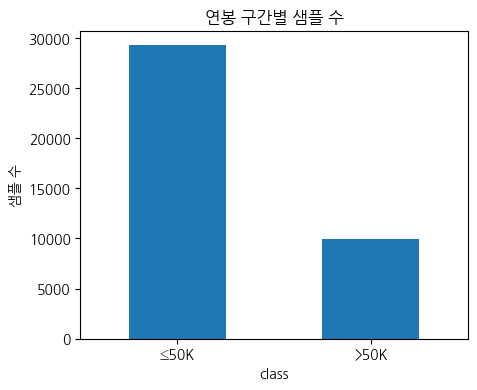

In [7]:
# 막대 그래프로 시각화
plt.figure(figsize=(5,4))
target_counts.plot(kind='bar')
plt.title("연봉 구간별 샘플 수")
plt.ylabel("샘플 수")
plt.xticks(rotation=0)
plt.show()


## 4. 학습용 / 평가용 데이터 분리

머신러닝 모델의 **일반화 성능**을 평가하기 위해 데이터셋을 나눈다.

- `train_df` : 모델 학습에 사용 (60%)
- `test_df` : 최종 성능 평가에 사용 (40%)
- `stratify=y` 옵션으로 타깃 비율을 유지한 채로 나눈다.


In [8]:
# 전체 데이터 복사
df = data.copy()

# 학습/테스트 분할
train_df, test_df = train_test_split(
    df,
    test_size=0.4,
    stratify=df['class'],
    random_state=10
)

print("train_df shape:", train_df.shape)
print("test_df shape:", test_df.shape)

train_df.head()


train_df shape: (23544, 14)
test_df shape: (15696, 14)


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
21251,32,State-gov,7th-8th,4,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,19,United-States,0
3994,38,State-gov,Some-college,10,Divorced,Exec-managerial,Unmarried,White,Female,0,0,40,United-States,0
1871,58,Private,Bachelors,13,Widowed,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,1
16563,27,Private,HS-grad,9,Never-married,Craft-repair,Own-child,White,Female,0,0,45,United-States,0
16892,46,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,40,United-States,1


## 5. AutoGluon Tabular 소개

`AutoGluon`은 **AutoML 라이브러리**로, 아래 작업들을 자동으로 해준다.

- 범주형/수치형 변수 자동 인코딩
- 여러 모델(GBM, CatBoost, XGBoost 등) 자동 탐색
- 하이퍼파라미터 튜닝
- 여러 모델을 앙상블하여 최종 성능 향상

우리는 단지:
1. **데이터프레임** 전체와  
2. **타깃 컬럼 이름(label)** 만 넘겨주면 된다.

이제 `TabularPredictor`를 이용해서 모델을 학습해보자.


### 5.1 TabularPredictor 설정 및 학습

- `label='class'` : 예측할 타깃 컬럼 이름  
- `problem_type='binary'` : 이진 분류 문제  
- `eval_metric='f1'` : 불균형 데이터에 유리한 F1 점수를 기준으로 최적 모델 선택  
- `presets="medium_quality_faster_train"` : 적당한 속도 + 괜찮은 성능  
- `time_limit=600` : 최대 학습 시간(초) 설정 (환경에 따라 조정 가능)


In [9]:
save_path = "autogluon_salary_model/"  # 모델 및 로그 저장 경로

predictor = TabularPredictor(
    label='class',           # 타깃 컬럼 이름
    problem_type='binary',   # 이진분류
    eval_metric='f1',        # 평가 지표 (불균형 데이터에 유리)
    path=save_path
)

# presets:
# - "medium_quality_faster_train": 적당한 속도 + 괜찮은 성능
# - "best_quality": 시간 오래 걸리지만 최상 성능  (데이터 크기에 따라 조정)
# time_limit: 초 단위 제한 (예: 600 = 10분)
predictor = predictor.fit(
    train_data=train_df,
    presets="best_quality",
    time_limit=600,  # 필요에 따라 증가/감소
    verbosity=2
)


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.9.23
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26200
CPU Count:          12
Memory Avail:       6.17 GB / 17.85 GB (34.6%)
Disk Space Avail:   526.62 GB / 930.73 GB (56.6%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is use

Fitting model: CatBoost_BAG_L1 ... Training model for up to 43.21s of the 93.13s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy (sequential: cpus=6, gpus=0)
	Ran out of time, early stopping on iteration 80.
	Ran out of time, early stopping on iteration 82.
	Ran out of time, early stopping on iteration 75.
	Ran out of time, early stopping on iteration 73.
	Ran out of time, early stopping on iteration 77.
	Ran out of time, early stopping on iteration 96.
	Ran out of time, early stopping on iteration 93.
	Ran out of time, early stopping on iteration 108.
	0.6822	 = Validation score   (f1)
	41.24s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: ExtraTreesGini_BAG_L1 ... Training model for up to 1.79s of the 51.71s of remaining time.
	0.6333	 = Validation score   (f1)
	1.32s	 = Training   runtime
	0.86s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 149.75s of the 48.90s of r

	Available Memory:                    6012.35 MB
	Train Data (Original)  Memory Usage: 13.02 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])    : 5 | ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
		('object', []) : 8 | ['workclass', 'education', 'marital-status', 'occupation', 'relationship', ...

[1000]	valid_set's binary_logloss: 0.305184	valid_set's f1: 0.70255


	0.7065	 = Validation score   (f1)
	25.45s	 = Training   runtime
	0.23s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 270.17s of the 418.32s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy (sequential: cpus=6, gpus=0)
	0.7195	 = Validation score   (f1)
	15.07s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: RandomForestGini_BAG_L1 ... Training model for up to 254.86s of the 403.01s of remaining time.
	0.6447	 = Validation score   (f1)
	1.39s	 = Training   runtime
	0.75s	 = Validation runtime
Fitting model: RandomForestEntr_BAG_L1 ... Training model for up to 252.37s of the 400.52s of remaining time.
	0.6435	 = Validation score   (f1)
	1.33s	 = Training   runtime
	0.72s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 250.01s of the 398.16s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrate

## 6. 리더보드(LeaderBoard)로 모델 비교

`predictor.leaderboard(test_df)`를 사용하면,  
AutoGluon이 학습한 **여러 모델들의 성능을 한 번에 비교**할 수 있다.

- `score_val` : 검증 데이터 기준 점수 (학습 중 내부 검증)
- `score_test` : 우리가 넣어준 `test_df` 기준 점수  
- `pred_time_*`, `fit_time` : 예측/학습 시간


In [10]:
leaderboard = predictor.leaderboard(test_df, silent=False)
leaderboard


                      model  score_test  score_val eval_metric  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           CatBoost_BAG_L2    0.742312   0.729401          f1        3.850832       3.689504  398.887836                 0.178089                0.050480         108.824239            2       True         14
1         LightGBMXT_BAG_L2    0.741009   0.738428          f1        4.275345       3.731467  304.849704                 0.602601                0.092443          14.786108            2       True         10
2       WeightedEnsemble_L3    0.741009   0.738428          f1        4.289529       3.734475  305.748192                 0.014185                0.003008           0.898487            3       True         16
3     ExtraTreesGini_BAG_L2    0.740018   0.734444          f1        3.973599       4.271600  291.185914                 0.300856                0.632576          

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,CatBoost_BAG_L2,0.742312,0.729401,f1,3.850832,3.689504,398.887836,0.178089,0.050480,108.824239,2,True,14
1,LightGBMXT_BAG_L2,0.741009,0.738428,f1,4.275345,3.731467,304.849704,0.602601,0.092443,14.786108,2,True,10
2,WeightedEnsemble_L3,0.741009,0.738428,f1,4.289529,3.734475,305.748192,0.014185,0.003008,0.898487,3,True,16
3,ExtraTreesGini_BAG_L2,0.740018,0.734444,f1,3.973599,4.271600,291.185914,0.300856,0.632576,1.122318,2,True,15
4,LightGBM_BAG_L2,0.738679,0.730454,f1,4.054966,3.691694,300.748871,0.382223,0.052670,10.685274,2,True,11
5,RandomForestGini_BAG_L2,0.737884,0.726911,f1,3.938398,4.205125,292.249615,0.265655,0.566101,2.186019,2,True,12
6,RandomForestEntr_BAG_L2,0.737820,0.729800,f1,3.923714,4.190745,292.748677,0.250971,0.551721,2.685080,2,True,13
7,LightGBM_BAG_L1,0.732225,0.719462,f1,0.487346,0.085724,15.066691,0.487346,0.085724,15.066691,1,True,2
8,WeightedEnsemble_L2,0.732225,0.719462,f1,0.503162,0.089778,15.578146,0.015816,0.004055,0.511455,2,True,9
9,CatBoost_BAG_L1,0.730402,0.711503,f1,0.212019,0.058033,239.585711,0.212019,0.058033,239.585711,1,True,5


## 7. 예측 & 성능 평가

학습된 AutoGluon 모델로 테스트 데이터를 예측해 보고,  
다음과 같은 지표로 성능을 평가한다.

- **분류 리포트(classification_report)** : Precision, Recall, F1 등
- **혼동행렬(confusion_matrix)** : 실제/예측 조합표
- **ROC-AUC 점수** : 양성 클래스(연봉 >50K) 구분 능력


In [11]:
# 실제 타깃
y_true = test_df['class']

# 예측(0/1)
y_pred = predictor.predict(test_df)

# 양성 클래스(1)에 대한 예측 확률
y_proba = predictor.predict_proba(test_df)[1]

print("===== Classification Report =====")
print(classification_report(y_true, y_pred))

print("\n===== Confusion Matrix =====")
print(confusion_matrix(y_true, y_pred))

print("\n===== ROC-AUC =====")
print(roc_auc_score(y_true, y_proba))


===== Classification Report =====
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     11706
           1       0.74      0.74      0.74      3990

    accuracy                           0.87     15696
   macro avg       0.83      0.83      0.83     15696
weighted avg       0.87      0.87      0.87     15696


===== Confusion Matrix =====
[[10655  1051]
 [ 1023  2967]]

===== ROC-AUC =====
0.9302363845715433


### 7.1 Confusion Matrix 시각화

혼동행렬을 **히트맵 형태**로 시각화하면,  
모델이 어느 클래스를 더 많이 틀리는지 직관적으로 볼 수 있다.

- (0,0): 실제 0을 0으로 맞춘 개수 (TN)
- (0,1): 실제 0을 1로 잘못 예측한 개수 (FP)
- (1,0): 실제 1을 0으로 잘못 예측한 개수 (FN)
- (1,1): 실제 1을 1로 맞춘 개수 (TP)


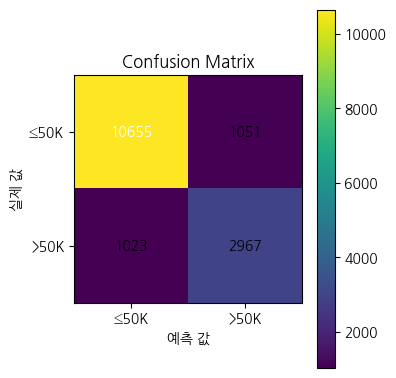

In [12]:
from matplotlib.colors import LogNorm

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['≤50K', '>50K'])
plt.yticks(tick_marks, ['≤50K', '>50K'])

plt.ylabel('실제 값')
plt.xlabel('예측 값')

# 각 칸에 숫자 표시
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


## 8. Feature Importance(변수 중요도) 분석

`predictor.feature_importance(test_df)`를 사용하면  
**어떤 특성(feature)이 연봉 예측에 더 큰 영향을 미치는지** 알 수 있다.

이 정보를 활용하면:
- 어떤 변수들이 중요한지 설명할 수 있고
- 불필요한 변수를 줄이거나,
- 중요한 변수에 대해 추가 분석(EDA)을 할 수 있다.


In [13]:
fi = predictor.feature_importance(test_df)
fi.head()


Computing feature importance via permutation shuffling for 13 features using 5000 rows with 5 shuffle sets...
	167.64s	= Expected runtime (33.53s per shuffle set)
	60.65s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
capital-gain,0.121674,0.007774,1.988882e-06,5,0.137680,0.105667
marital-status,0.075371,0.007062,9.143415e-06,5,0.089913,0.060829
occupation,0.066567,0.003336,7.546221e-07,5,0.073436,0.059698
age,0.061481,0.010469,9.711033e-05,5,0.083038,0.039925
relationship,0.042783,0.005702,3.699530e-05,5,0.054524,0.031041


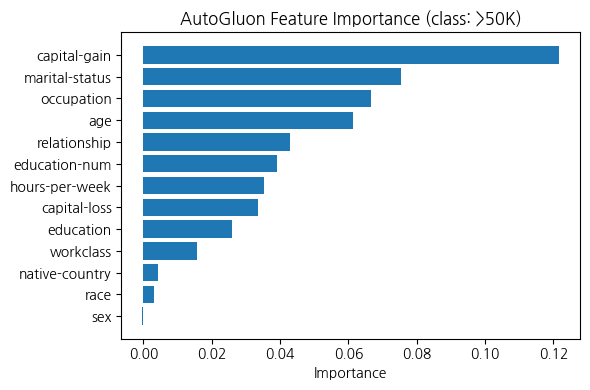

In [14]:
# 중요도 기준으로 정렬 후 시각화
fi_sorted = fi.sort_values("importance", ascending=True)

plt.figure(figsize=(6, max(4, len(fi_sorted) * 0.3)))
plt.barh(fi_sorted.index, fi_sorted["importance"])
plt.title("AutoGluon Feature Importance (class: >50K)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


## 9. 정리

이번 노트북에서는 다음 내용을 다루었다.

1. `salary2.csv` 연봉 데이터 불러오기 및 기본 전처리
2. 타깃 변수 `class`를 0/1 이진 변수로 변환
3. 학습 데이터/테스트 데이터 분리 (`train_test_split`)
4. **AutoGluon TabularPredictor**를 이용한 AutoML 분류 모델 학습
5. 리더보드를 통해 여러 모델의 성능 비교
6. Confusion Matrix, Classification Report, ROC-AUC로 모델 평가
7. Feature Importance로 **연봉에 영향을 주는 주요 변수** 해석

> 수업에서 활용할 때는,  
> - 먼저 기존의 `DecisionTree`, `RandomForest` 등을 직접 튜닝해본 뒤  
> - 같은 데이터를 AutoGluon에 넣어 성능 차이와 개발 편의성을 비교해 보는 활동  
> 을 함께 진행하면 학습 효과가 매우 좋다.
